# Imports and Setup

In [213]:
import sys
assert sys.version_info >= (3, 5)

import numpy as np
import pandas as pd
import random
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import optproblems.cec2005 as opt
import optproblems.base as base

# Helper Functions

In [214]:
def eval(func, position):
    pos = base.Individual(position)
    func.evaluate(pos)
    return pos.objective_values

def show_func(func, range):
    x, y = np.array(np.meshgrid(np.linspace(range[0],range[1],100), np.linspace(range[0],range[1],100)))
    z = func([x, y])
    x_min = x.ravel()[z.argmin()]
    y_min = y.ravel()[z.argmin()]
    plt.figure(figsize=(8,6))
    plt.imshow(z, extent=[range[0], range[1], range[0], range[1]], origin='lower', cmap='viridis', alpha=0.5)
    plt.colorbar()
    plt.plot([x_min], [y_min], marker='x', markersize=5, color="white")
    contours = plt.contour(x, y, z, 10, colors='black', alpha=0.4)
    plt.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
    plt.show()

# Benchmark Functions

In [215]:
def rastrigin(input):
    result = 10*len(input)
    for x in input:
        result += x**2 - 10 * (np.cos(2 * np.pi * x))
    return result

def sphere(input):
    result = 0
    for x in input:
        result += x**2
    return result

def rosenbrock(input):
    result = 0
    for i in range(len(input) - 1):
        result += 100*(input[i+1] - input[i]**2)**2 + (1 - input[i])**2
    return result

def styblinski_tang(input):
    result = 0
    for x in input:
        result += x**4 - 16*x**2 + 5*x
    return result/2

# Particle Swarm Optimisation Algorithm

### Particle Class

In [216]:
class Particle:
    def __init__(self, numInputs, domain, func, weights):
        self.position = []
        self.velocity = []
        self.bestPos = []
        self.informants: list[Particle] = []
        self.func = func
        self.domain = domain
        self.dimensions = numInputs
        self.weights = weights

        for i in range(numInputs):
            self.position.append(random.uniform(domain[0], domain[1]))
            self.velocity.append(random.uniform(domain[0]/10, domain[1]/10))
 
        self.result = eval(func, self.position)
        self.bestResult = self.result
        self.bestPos = self.position
    
    def evaluate(self):
        self.result = eval(self.func, self.position)

        if self.result < self.bestResult:
            self.bestResult = self.result
            self.bestPos = self.position

    def update_velocity(self, globalBestPos):
        bestInformant = self.informants[0]
        for particle in self.informants:
            if particle.bestResult < bestInformant.bestResult:
                bestInformant = particle

        for i in range(self.dimensions):
            cognitive = random.uniform(0, self.weights[1])*(self.bestPos[i] - self.position[i])
            social = random.uniform(0, self.weights[2])*(bestInformant.bestPos[i] - self.position[i])
            globalv = random.uniform(0, self.weights[3])*(globalBestPos[i] - self.position[i])
            self.velocity[i] = self.weights[0]*self.velocity[i] + cognitive + social + globalv
    
    def update_position(self):
        for i in range(self.dimensions):
            self.position[i] += self.weights[4] * self.velocity[i]
            
            if self.position[i] < self.domain[0]:
                self.position[i] = self.domain[0]
            elif self.position[i] > self.domain[1]:
                self.position[i] = self.domain[1]

### Particle Swarm Optimization Algorithm Class

In [217]:
class PSO():
    def __init__(self, numInputs, domain, func, weights, swarmSize, numInformants, maxIter):
        self.swarm: list[Particle] = []
        self.swarmSize = swarmSize
        self.maxIter = maxIter
        self.domain = domain
        self.func = func
        self.initSwarm = []

        for i in range(swarmSize):
            particle = Particle(numInputs, domain, func, weights)
            self.swarm.append(particle)
            self.initSwarm.append(particle.position.copy())
        
        for i in range(swarmSize):
            while len(self.swarm[i].informants) < numInformants:
                inform = random.choice(self.swarm)
                if self.swarm[i].informants.__contains__(inform) or self.swarm[i] == inform:
                    continue
                else:
                    self.swarm[i].informants.append(inform)


    def optimize(self):
        i = 0
        globalBest = self.swarm[0]
        while i < self.maxIter:
            for j in range(self.swarmSize):
                self.swarm[j].evaluate()
            
            for j in range(self.swarmSize):
                if self.swarm[j].bestResult < globalBest.bestResult:
                    globalBest = self.swarm[j]

            for j in range(self.swarmSize):
                self.swarm[j].update_velocity(globalBest.bestPos)
                self.swarm[j].update_position()

            i+=1

        print("Solution:")
        print(globalBest.bestPos)
        print("Result:")
        print(globalBest.bestResult)
        self.globalBest = globalBest

    def display(self):              # display the solution on a graph (iff solution size is 2)
        ## plot from blog 

        boundT = 2*self.domain[1]

        # initialise two 2D arrays to represent the x and y coordinates for the graph of the function from optproblems 
        x, y = np.array(np.meshgrid(np.linspace(-self.domain[1],self.domain[1],boundT), np.linspace(-self.domain[1],self.domain[1],boundT)))

        # creates a 2D array to store the function result to be graphed 
        z = np.zeros([boundT, boundT])


        for i in range(boundT):                                             # for every row 
            for j in range(boundT):                                           # for every element
                plotSoln = base.Individual(np.array([x[i][j], y[i][j]])) # create a solution using the coordinates
                self.func.evaluate(plotSoln)                                    # evaluate the solution
                z[i][j] = plotSoln.objective_values                             # add the evaluation of the solution to z

        # set up arrays for scattering the first and final generations on the graph
        xFirst = np.zeros(self.swarmSize)                                          
        yFirst = np.zeros(self.swarmSize)
        xFinal = np.zeros(self.swarmSize) 
        yFinal = np.zeros(self.swarmSize)

        # get the coordinates for the first generation 
        for i in range(self.swarmSize):
            xFirst[i] = self.initSwarm[i][0]
            yFirst[i] = self.initSwarm[i][1]

        # get the coordinates for the last generation 
        for i in range(self.swarmSize):
            xFinal[i] = self.swarm[i].position[0]
            yFinal[i] = self.swarm[i].position[1]

        # get the coordinates of the optimal(smallest) point on the function
        x_min = x.reshape(-1)[z.argmin()]     # flatten the array of x coordinates and find the value with the same index as to the smallest value of z 
        y_min = y.reshape(-1)[z.argmin()]     # flatten the array of y coordinates and find the value with the same index as to the smallest value of z 

        # adjust the size of the plot in inches 
        #plt.figure(figsize=(8,6))

        # plot the image of the function from optproblems within the bounds supplied 
        plt.imshow(z, extent=[-self.domain[1], self.domain[1], -self.domain[1], self.domain[1]], origin='lower', cmap='PuBuGn', alpha=1)

        # display the colourbar to illustrate the depth (z)
        plt.colorbar()

        # plot the optimal solution with a black x
        plt.plot([x_min], [y_min], marker='x', markersize=5, color="black", label="Optimal")

        # plot the best solution with a black triange
        plt.plot(self.globalBest.bestPos[0], self.globalBest.bestPos[1], marker='^', markersize=5, color="black", label="Best")

        # plot the contours of the function 
        contours = plt.contour(x, y, z, colors='black', alpha=0.4)
        plt.clabel(contours, inline=True, fontsize=8, fmt="%.0f")

        # plot the coordinates which represent the solutions from the first generation 
        plt.scatter(xFirst, yFirst, 5, c="orange", label="first generation")

        # plot the coordinates which represent the solutions from the last generation   
        plt.scatter(xFinal, yFinal, 5, c="red", label="last generation")

        # show the legend
        plt.legend()

        # show the graph
        plt.show()


# Runnning and Testing

Solution:
[37.71414894041482, -82.67820066922897]
Result:
-449.65216389267863


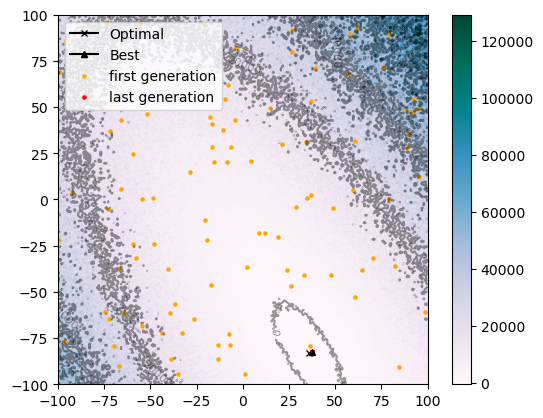

In [218]:
#show_func(sphere, [-100, 100])
pso = PSO(2, [-100, 100], opt.F4(2), [0.5, 0.5, 0.5, 0.5, 0.5], 100, 10, 1000)
pso.optimize()
pso.display()